In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from numpy import log, exp, sqrt

In [30]:
a = 0
b = 0
def f(q):
    return logp(q), grad(q)

def logp(q):
    return -0.5 * ((q[0]+a)**2 + (q[1]+b)**2)


def grad(q):
    grad = np.zeros(2)
    grad[0] = -(q[0]+a)
    grad[1] = -(q[1]+b)  
    return grad

def target_density(q):
    return (1 / (2 * np.pi)) * np.exp(-0.5 * ((q[0]+a)**2 + (q[1]+b)**2))
'''

def f(q):
    return logp(q), grad(q)

def logp(q):
    return -0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1])


def grad(q):
    grad = np.zeros(2)
    grad[0] = -q[0]*q[1]**2 + q[0] - 4
    grad[1] = -q[1]*q[0]**2 + q[1] - 4   
    return grad


def target_density(q):
    return np.exp(-0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1]))
'''

'\n\ndef f(q):\n    return logp(q), grad(q)\n\ndef logp(q):\n    return -0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1])\n\n\ndef grad(q):\n    grad = np.zeros(2)\n    grad[0] = -q[0]*q[1]**2 + q[0] - 4\n    grad[1] = -q[1]*q[0]**2 + q[1] - 4   \n    return grad\n\n\ndef target_density(q):\n    return np.exp(-0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1]))\n'

In [31]:
def get_angle(a, b):
    # 计算向量的点积
    dot_product = np.dot(a, b)
    
    # 计算向量的模长
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    # 计算cos值
    cos_theta = dot_product / (norm_a * norm_b)
    
    # 计算夹角（以弧度为单位）
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    
    # 将弧度转换为角度
    angle_in_degrees = np.degrees(theta)
    #print(angle_in_degrees)
    return angle_in_degrees

In [32]:
def update_PQUT(x_mem, grad_mem, U_mem, B1):
    Nq = np.shape(x_mem)[1]
    #print(x_mem, grad_mem)
    # firstly sort previous {xi} in ascending order with respect to its log function    
    o = np.argsort(U_mem)

    S = np.array([])
    Y = np.array([])
    v_last = 0
    v_next = 1
    init = True
    while v_next < len(o):
        sk = x_mem[v_next, :] - x_mem[v_last, :]  #s_k = x_{k+1} - x_k, vector
        yk = grad_mem[v_next, :] - grad_mem[v_last,:]  #y_k = f'_{k+1} - f'_k
        #sk = x_mem[o[v_next], :] - x_mem[o[v_last], :]  #s_k = x_{k+1} - x_k, vector
        #yk = grad_mem[o[v_next], :] - grad_mem[o[v_last],:]  #y_k = f'_{k+1} - f'_k
        
        if np.dot(sk, yk.T) > 0:
        #print(np.dot(sk, yk.T),get_angle(sk, yk.T) )
        #theta = get_angle(sk, yk.T) 
        #if (theta <= 95 and theta >= 0.):
            v_last = v_next
            v_next = v_next + 1
            if init:
                S = np.hstack((S.copy(),sk.T))
                Y = np.hstack((Y.copy(),yk.T))
                init = False
            else:
                S = np.vstack((S.copy(),sk.T))
                Y = np.vstack((Y.copy(),yk.T))
        else:
            v_next += 1

    if S.shape == (2,):
        S = S.reshape((1, 2))
        Y = Y.reshape((1, 2))
    
    vn = np.shape(S)[0]
    P = np.zeros((Nq, vn))
    Q = np.zeros((Nq, vn))
    U = np.array([])
    T = np.array([])

    init =True
    #print(S.shape)
    for k in range(vn):
        syk = np.dot(S[k,:].T, Y[k,:])
        Bsk = Bz_product(U, T, B1, S[k,:])
        sBsk = np.dot(S[k,:].T, Bsk)

        P[:, k] = S[k,:] / syk
        Q[:, k] = np.dot(np.sqrt(syk/sBsk), Bsk) + Y[k,:]    
        t_k = S[k,:]/sBsk
        u_k = np.dot(np.sqrt(sBsk/syk), Y[k,:])+Bsk
        
        if init:
            T= np.hstack((T.copy(),t_k))
            U= np.hstack((U.copy(),u_k))
            init = False
        else:
            T= np.vstack((T.copy(),t_k)) #np.vstack((T.copy(),t_k))
            U= np.vstack((U.copy(),u_k))   #dimension: Vn x Nq

    return P, Q, U, T

In [33]:
def Bz_product(U, T, B1, z):
    #B = CC^T
    if U.size == 0:
        Bz = np.dot(B1, z)
        return Bz
    # compute C^T s
    CTz = CTz_product(U, T, B1, z)
    # compute Ns = CC^T s
    Bz = Cz_product(U, T, B1, CTz)
    return Bz
        
def CTz_product(U, T, B1, z):
    # compute C^T * sk
    C1 = np.sqrt(B1)
    Csk = z
    try:
        m = np.shape(U)[1]
    except:
        m = 1

    if m==1:
        Csk = Csk - np.dot(np.dot(U.T, Csk), T)
    else:
        for k in range(m-1, -1, -1):
        #for k in reversed(range(m))
            Csk = Csk - np.dot(np.dot(U[k,:].T, Csk), T[k,:])
    
    CTz = np.dot(C1, Csk)
    return CTz

def Cz_product(U, T, B1, z):
    # compute C * CTs = C * C^T * sk
    # or compute C * z, where z ~ N(0,I)
    C1 = np.sqrt(B1)
    CCTsk = np.dot(C1, z)

    try:
        m = np.shape(U)[1]
    except:
        m = 1

    if m == 1:
        CCTsk = CCTsk - np.dot(np.dot(T.T, CCTsk), U)
    else:
        for k in range(m):
            CCTsk = CCTsk - np.dot(np.dot(T[k,:].T, CCTsk), U[k,:])   # Ck - uk * tk^T *Ck
   
    CCTz = CCTsk
    return CCTz

In [34]:
def Hz_product(P, Q, B1, z):
    # H = SS^T
    #if P.size == 0:
     #   Hz = np.linalg.inv(B1) @ z
    # compute S^Tz
    STz = STz_product(P, Q, B1, z)
    # compute SS^Tz
    Hz = Sz_product(P, Q, B1, STz)
    return Hz

def STz_product(P, Q, B1, z):
    # compute S^Tz
    S1 = np.diag(np.sqrt(np.diag(B1)))
    m = P.shape[1]
    Siz = z.copy()
    for i in reversed(range(m)):
        Siz -= np.dot(np.dot(P[:, i].T, Siz), Q[:, i])

    STz = np.dot(S1, Siz)
    return STz

def Sz_product(P, Q, B1, z):
    S1 = np.diag(np.sqrt(np.diag(B1)))
    m = P.shape[1]
    Siz = np.dot(S1, z)
    for i in range(m):
        Siz -= np.dot(np.dot(Q[:, i].T, Siz), P[:, i])
    Sz = Siz
    return Sz

In [35]:
def create_p(Nq):
    p = np.random.normal(loc=0, scale=1.0, size=Nq) 
    return p


def Kp(p, P, Q, B1):
    return 0.5 * np.dot(p, Hz_product(P, Q, B1, p.T)) 

In [36]:
def leapfrog_BFGS(theta, r, grad, epsilon, f, P, Q, B1):
    
    # make half step in r
    rprime = r + 0.5 * epsilon * grad
    # make new step in theta
    #thetaprime = theta + epsilon * rprime
    thetaprime = theta + epsilon * Hz_product(P, Q, B1, rprime.T).T  #massinv @ p
    #compute new gradient
    logpprime, gradprime = f(thetaprime)
    # make half step in r again
    rprime = rprime + 0.5 * epsilon * gradprime
    
    return thetaprime, rprime, gradprime, logpprime


def find_reasonable_epsilon(theta0, grad0, logp0, f, P, Q, B1):
    """ Heuristic for choosing an initial value of epsilon """
    epsilon = 1.
    Nq = len(theta0)
    r0 = np.random.normal(0., 1., Nq)

    # Figure out what direction we should be moving epsilon.
    _, rprime, gradprime, logpprime = leapfrog_BFGS(theta0, r0, grad0, epsilon, f, P, Q, B1)
    # brutal! This trick make sure the step is not huge leading to infinite
    # values of the likelihood. This could also help to make sure theta stays
    # within the prior domain (if any)
    k = 1.
    while np.isinf(logpprime) or np.isinf(gradprime).any():
        k *= 0.5
        _, rprime, _, logpprime = leapfrog_BFGS(theta0, r0, grad0, epsilon * k, f, P, Q, B1)

    epsilon = 0.5 * k * epsilon

    # acceptprob = np.exp(logpprime - logp0 - 0.5 * (np.dot(rprime, rprime.T) - np.dot(r0, r0.T)))
    # a = 2. * float((acceptprob > 0.5)) - 1.
    #logacceptprob = logpprime-logp0-0.5*(np.dot(rprime, rprime)-np.dot(r0,r0))
    logacceptprob = logpprime-logp0-(Kp(rprime, P, Q, B1)-Kp(r0, P, Q, B1))
    a = 1. if logacceptprob > np.log(0.5) else -1.
    # Keep moving epsilon in that direction until acceptprob crosses 0.5.
    # while ( (acceptprob ** a) > (2. ** (-a))):
    while a * logacceptprob > -a * np.log(2):
        epsilon = epsilon * (2. ** a)
        _, rprime, _, logpprime = leapfrog_BFGS(theta0, r0, grad0, epsilon, f, P, Q, B1)
        # acceptprob = np.exp(logpprime - logp0 - 0.5 * ( np.dot(rprime, rprime.T) - np.dot(r0, r0.T)))
        #logacceptprob = logpprime-logp0-0.5*(np.dot(rprime, rprime)-np.dot(r0,r0))
        logacceptprob = logpprime-logp0-(Kp(rprime, P, Q, B1)-Kp(r0, P, Q, B1))

    print("find_reasonable_epsilon=", epsilon)

    return epsilon


def stop_criterion(thetaminus, thetaplus, rminus, rplus):
    """ Compute the stop condition in the main loop
    dot(dtheta, rminus) >= 0 & dot(dtheta, rplus >= 0)

    INPUTS
    ------
    thetaminus, thetaplus: ndarray[float, ndim=1]
        under and above position
    rminus, rplus: ndarray[float, ndim=1]
        under and above momentum

    OUTPUTS
    -------
    criterion: bool
        return if the condition is valid
    """
    dtheta = thetaplus - thetaminus
    return (np.dot(dtheta, rminus.T) >= 0) & (np.dot(dtheta, rplus.T) >= 0)


def build_tree(theta, r, grad, logu, v, j, epsilon, f, joint0, P, Q, B1):
    """The main recursion."""
    if (j == 0):
        # Base case: Take a single leapfrog step in the direction v.
        thetaprime, rprime, gradprime, logpprime = leapfrog_BFGS(theta, r, grad, v * epsilon, f, P, Q, B1)
        #joint = logpprime - 0.5 * np.dot(rprime, rprime.T)
        joint = logpprime - Kp(rprime, P, Q, B1)
        # Is the new point in the slice?
        nprime = int(logu < joint)
        # Is the simulation wildly inaccurate?
        sprime = int((logu - 1000.) < joint)
        # Set the return values---minus=plus for all things here, since the
        # "tree" is of depth 0.
        thetaminus = thetaprime[:]
        thetaplus = thetaprime[:]
        rminus = rprime[:]
        rplus = rprime[:]
        gradminus = gradprime[:]
        gradplus = gradprime[:]
        # Compute the acceptance probability.
        alphaprime = min(1., np.exp(joint - joint0))
        #alphaprime = min(1., np.exp(logpprime - 0.5 * np.dot(rprime, rprime.T) - joint0))
        nalphaprime = 1
    else:
        # Recursion: Implicitly build the height j-1 left and right subtrees.
        thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime = build_tree(theta, r, grad, logu, v, j - 1, epsilon, f, joint0, P, Q, B1)
        # No need to keep going if the stopping criteria were met in the first subtree.
        if (sprime == 1):
            if (v == -1):
                thetaminus, rminus, gradminus, _, _, _, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = build_tree(thetaminus, rminus, gradminus, logu, v, j - 1, epsilon, f, joint0, P, Q, B1)
            else:
                _, _, _, thetaplus, rplus, gradplus, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = build_tree(thetaplus, rplus, gradplus, logu, v, j - 1, epsilon, f, joint0, P, Q, B1)
            # Choose which subtree to propagate a sample up from.
            if (np.random.uniform() < (float(nprime2) / max(float(int(nprime) + int(nprime2)), 1.))):
                thetaprime = thetaprime2[:]
                gradprime = gradprime2[:]
                logpprime = logpprime2
            # Update the number of valid points.
            nprime = int(nprime) + int(nprime2)
            # Update the stopping criterion.
            sprime = int(sprime and sprime2 and stop_criterion(thetaminus, thetaplus, rminus, rplus))
            # Update the acceptance probability statistics.
            alphaprime = alphaprime + alphaprime2
            nalphaprime = nalphaprime + nalphaprime2

    return thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime



In [37]:
def set_memmory(K, Nq):
    sample_mem = np.random.rand(K, Nq)
    x_mem = sample_mem[1:, :]  # x_{2:k}, //matrix//  K-1 x Nq dims
    grad_mem = np.zeros((K-1, Nq))  # gradient, //matrix//  K-1 x Nq dims
    U_mem = np.zeros(K-1)  # potential energy, //vector// K-1 dims

    # save potential energy and gradient for previous 2:K samples
    for i in range(K-1):
        logp, grad = f(x_mem[i, :])
        U_mem[i] = -logp
        grad_mem[i,:] = -grad

    q0  = sample_mem[0, :]  # x_1^(t)
    logp0, grad0 = f(q0)

    return q0, logp0, grad0, x_mem, U_mem, grad_mem



def hmcbfgs_nut(f, M, Madapt, K, gamma_H, delta):
    Nq=2
    k = K - 1  # selected previous 2:K samples
    acprate = 0
    rejrate = 0
    samples = []

    ### Initalize memory excluding the first sample in the memory ###
    B1 = np.eye(Nq) * gamma_H # Initialize the starting Hessian matrix (mass matrix)
    q, logp, grad, x_mem, U_mem, grad_mem = set_memmory(K, Nq)
    P, Q, U, T = update_PQUT(x_mem, grad_mem, U_mem, B1)
    
    # Initialize dual averaging algorithm.
    epsilonbar = 1
    Hbar = 0
    
    epsilon = find_reasonable_epsilon(q, grad, logp, f, P, Q, B1)
     # Parameters to the dual averaging algorithm.
    gamma = 0.05
    t0 = 10
    kappa = 0.75
    mu = log(10. * epsilon)

    ### Start HMC sampling ....... ###
    for m in range(1, 100000):
        if len(samples) >= M + Madapt+1:
            break
        if np.mod(m,500) == 0:
            print('sampling iteration {}'.format(m))

        # precompute BFGS-conjugate matrices
        if m != 1:
            P, Q, U, T = update_PQUT(x_mem, grad_mem, U_mem, B1)

        # randomly draw momentum from B
        p = create_p(Nq)
        p = Cz_product(U, T, B1, p.T)  
        p = p.T

        # simulate trajectory
        #joint = logp - 0.5 * np.dot(p, p.T)
        joint = logp - Kp(p, P, Q, B1)
        
        # resample u ~ uniform([0, exp(joint)])
        logu = float(joint - np.random.exponential(1, size=1))

        # initialize the tree
        p_left, p_right = p, p
        q_left, q_right = q, q
        grad_left, grad_right = grad, grad
        
        j = 0 # initial height  
        n = 1
        s = 1 # will keep going until s == 0

        while s == 1:
            # choose a direction -1 = backwards, 1 = forwards
            #v = random.uniform(-1,1)
            v = int(2 * (np.random.uniform() < 0.5) - 1)

            # double the size of the tree
            if v == -1:
                q_left, p_left, grad_left, _,_,_, q_new, grad_new, logp_new, n_new, s_new, alpha, nalpha = build_tree(q_left, p_left, grad_left, logu, v, j, epsilon, f, joint, P, Q, B1)
            else:
                _, _, _, q_right, p_right, grad_right, q_new, grad_new, logp_new, n_new, s_new, alpha, nalpha = build_tree(q_right, p_right, grad_right, logu, v, j, epsilon, f, joint, P, Q, B1)

            q_next = x_mem[0, :]
            _tmp = min(1, float(n_new)/float(n))
            if s_new == 1 and (np.random.uniform() < _tmp):
                rejrate = 0
                # update memory
                x_mem = np.vstack((x_mem[1:, :], q_new))
                grad_mem = np.vstack((grad_mem[1:, :], -grad_new))
                U_mem = np.hstack((U_mem[1:], -logp_new))
                
                if m >= Madapt:
                    acprate += 1
                    samples.append(q_new)
            else:
                # update memory
                rejrate += 1
                '''
                x_mem = np.vstack((x_mem[1:, :], x_mem[-1, :]))
                grad_mem = np.vstack((grad_mem[1:, :], grad_mem[-1,:]))
                U_mem = np.hstack((U_mem[1:], U_mem[-1]))
                '''
                x_mem = np.vstack((x_mem[1:, :], q))
                grad_mem = np.vstack((grad_mem[1:, :], -grad))
                U_mem = np.hstack((U_mem[1:], -logp))
            
            q = q_next
            logp, grad = f(q)

            if rejrate > K-3:
                q, logp, grad, x_mem, U_mem, grad_mem = set_memmory(K, Nq)
                
            # update  number of valid points we've seen
            n = n + n_new
            # decide if it's time to stop
            s = s_new and stop_criterion(q_left, q_right, p_left, p_right)
            # increment depth
            j = j+1      

        # Do adaptation of epsilon if we're still doing burn-in
        eta = 1 / float(m + t0)
        Hbar = (1 - eta) * Hbar + eta * (delta - alpha / float(nalpha))
        if m <= Madapt:
            epsilon = np.exp(mu - np.sqrt(m) / gamma * Hbar)
            eta = m ** -kappa
            epsilonbar = np.exp((1 - eta) * np.log(epsilonbar) + eta * np.log(epsilon))
        else:
            epsilon = epsilonbar

        
    samples = np.array(samples)
    print('Acceptance_rate = {}'.format(acprate/m))
    return samples

In [38]:
random.seed(1)
M = 500
M_adapt =5000
k=5

gamma_H = 0.1
delta = 0.8

t_start = time.time()
print('Running NUT-HMC with L-BFGS')
samples = hmcbfgs_nut(f, M, M_adapt, k, gamma_H, delta)
t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))

Running NUT-HMC with L-BFGS
find_reasonable_epsilon= 16.0
sampling iteration 500
sampling iteration 1000
sampling iteration 1500
sampling iteration 2000
sampling iteration 2500
sampling iteration 3000
sampling iteration 3500
sampling iteration 4000
sampling iteration 4500
sampling iteration 5000
sampling iteration 5500
sampling iteration 6000
sampling iteration 6500
sampling iteration 7000
sampling iteration 7500
sampling iteration 8000
sampling iteration 8500
sampling iteration 9000
sampling iteration 9500
Acceptance_rate = 0.5507609130957148
Sampling Completed in 3.10 seconds


In [39]:
def plot_prediction(samples, target_density=target_density,save_file=None):

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 2], height_ratios=[2, 2], wspace=0.15, hspace=0.15)

    ax1 = fig.add_subplot(gs[0, 0])
    # generate grids
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)

    # compute the posterior density
    Z = target_density([X,Y])

    # plot samples

    ax1.plot(samples[:, 0], samples[:, 1], 'r+')
    # plot contour
    contour = plt.contour(X, Y, Z, cmap='viridis')
    ax1.clabel(contour, inline=1, fontsize=10)
    ax1.annotate(f'#Samples: {len(samples)}', xy=(5, 5), xytext=(5, 5),
                       ha='center', va='bottom')


    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.set_xlabel("x-samples")
    ax2.set_ylabel("density")
    data = samples[:,0]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax2.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax2.hist(data, bins=20,color='k',edgecolor='k',density=True, alpha=0.5)
    ax2.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax2.xaxis.set_tick_params(labelleft=False)


    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1) 
    ax3.set_ylabel("y-samples")
    ax3.set_xlabel("density")
    data = samples[:,1]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax3.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax3.hist(data, bins=20,color='k',edgecolor='k',alpha=0.5,density=True, orientation='horizontal')
    ax3.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax3.yaxis.set_tick_params(labelleft=False)

    ax_blank = fig.add_subplot(gs[1, 1])
    ax_blank.axis('off')

    plt.tight_layout()
    plt.show()
    


In [40]:
def autocorrelation(chain, lag):
    M = len(chain)
    mean = np.mean(chain)
    var = np.sum((chain - mean) ** 2) / M
    return np.sum((chain[:M-lag] - mean) * (chain[lag:] - mean)) / (M - lag) / var

def autocorrelation_function(chain, max_lag):
    return np.array([autocorrelation(chain, lag) for lag in range(max_lag)])

def integrated_autocorrelation_time(autocorr, M):
    # Use a cutoff when autocorrelation lower than 0.05
    cuttoff_autocorr = autocorr[autocorr > 0.05]
    M_cutoff = len(cuttoff_autocorr)

    sum = 0
    for s in range(M_cutoff):
        sum += cuttoff_autocorr[s] * (1 - s/M)
    
    return 1 + 2 * sum

def effective_sample_size(chain, max_lag):
    M = len(chain)
    autocorr = autocorrelation_function(chain, max_lag)
    tau = integrated_autocorrelation_time(autocorr, M)
    ess = M / tau
    return ess 

# 可视化自相关函数
def plot_autocorrelation(chain, max_lag, label,save_file=None):
    fig = plt.figure(figsize=(10, 10))
    autocorr = autocorrelation_function(chain, max_lag)
    lags = np.arange(max_lag)
    
    plt.figure(figsize=(10, 5))
    plt.stem(lags, autocorr, linefmt='lightblue')
    plt.xlabel('Lag')
    plt.ylabel(f'{label} Autocorrelation')
    plt.title('Autocorrelation Function')
    plt.axhline(y=0.05, color='g', linestyle='--', linewidth=1)
    plt.axhline(y=-0.05, color='g', linestyle='--', linewidth=1)
    plt.grid(True)
    if not save_file:
        plt.show()
    else:
        plt.savefig(save_file)


In [41]:
def plot_loglikelihood(A, alpha, save_file=None):
    fig = plt.figure(figsize=(10, 10))
    #plt.figure(1)
    alpha = 0
    # Print Monte-Carlo estimate of alpha.
    print("Mean:  " + str(np.mean(A)))
    per = np.percentile(A, [16, 50, 84])
    print("Alpha = {} (+{} / - {})".format( per[1], per[2] - per[1], per[1] - per[0] ))

    n, b = np.histogram(A, 30)
    x = 0.5 * (b[:-1] + b[1:])
    y = n.astype(float) / n.sum()
    plt.step(x, y, color='b', lw=3, where='mid')


    ylim = plt.ylim()
    plt.vlines(alpha, 0, ylim[1], color='r', lw=3)
    plt.vlines(per, 0., max(y), linestyle='--', color='b', lw=1)
    plt.ylim(ylim)
    plt.xlabel(r'$\alpha$', fontsize=24)
    plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)

    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()

/var/folders/st/h8zl89fn7f7gj0l06p3q5wj40000gn/T/ipykernel_33112/436616585.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


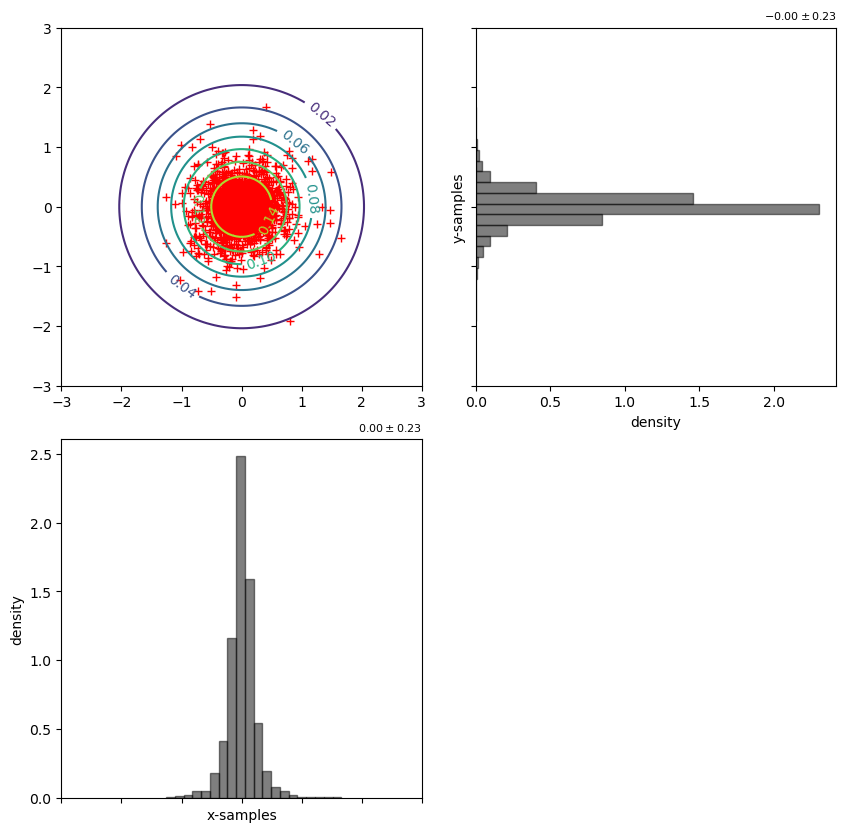

In [42]:
plot_prediction(samples, target_density)


Effective Sample Size (ESS): 1762.903751997892


<Figure size 1000x1000 with 0 Axes>

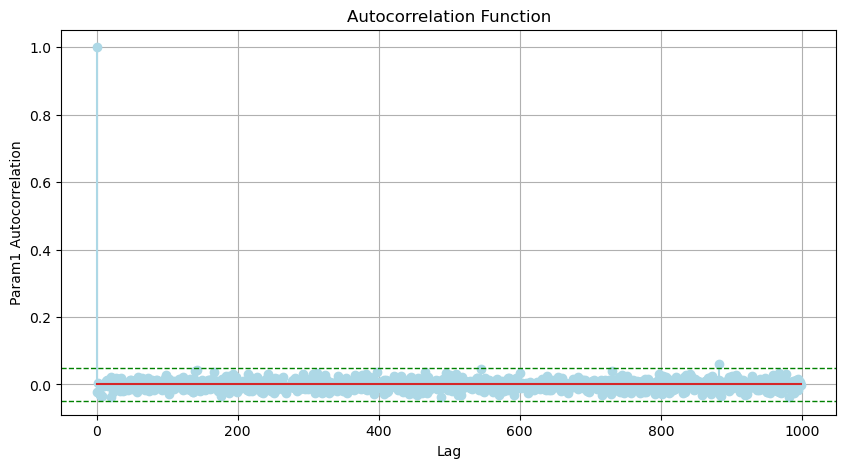

Mean:  0.0022269631700165965
Alpha = 0.002619964726239085 (+0.172319205586565 / - 0.17404784444803506)


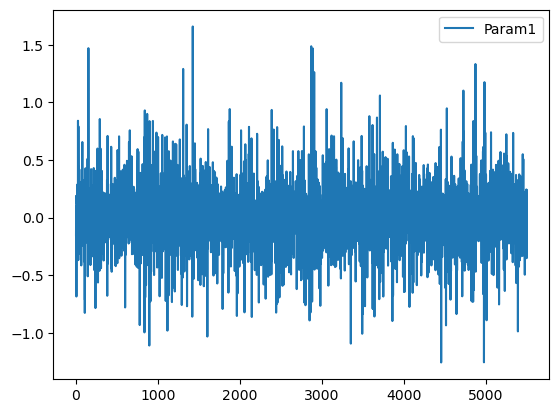

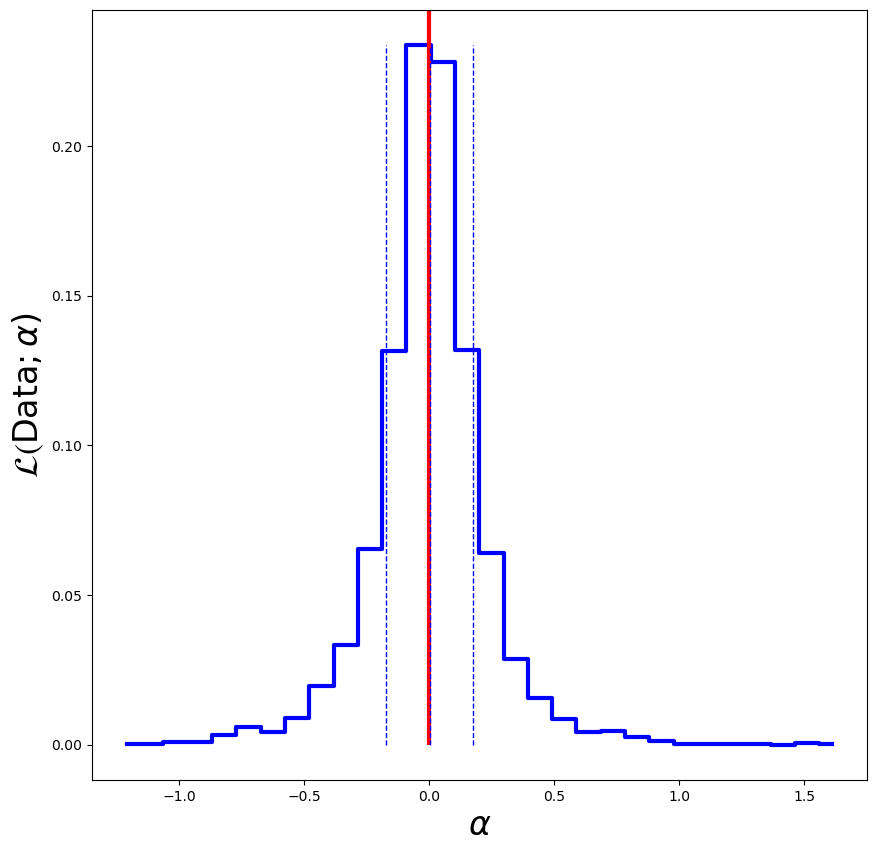

In [43]:
#  parameter 1
max_lag = 1000
data = samples[:,0]
ess = effective_sample_size(data, max_lag)
print("Effective Sample Size (ESS):", ess)
plot_autocorrelation(data, max_lag, label='Param1')
plt.plot(data, label='Param1')
plt.legend()

plot_loglikelihood(samples[:,0], 1)
